In [4]:
import tensorflow as tf
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
from tensorboard.plugins.scalar import metadata
import matplotlib.pyplot as plt

import numpy as np
import plotly.express as px
import pandas as pd
import os


def read_tensorboard_log(log_dir):
    event_file = tf.compat.v1.train.summary_iterator(log_dir)
    data = {}
    for event in event_file:
        if event.HasField('summary'):
            for value in event.summary.value:
                if value.tag not in data:
                    data[value.tag] = [[],[]]
                # print(value)
                data[value.tag][0].append(event.step)
                data[value.tag][1].append(tf.make_ndarray(value.tensor))

    return data



2023-08-17 12:07:07.260432: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-17 12:07:07.285132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 12:07:07.600530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
#function to get all log files in a directory
#Examples:
# logs = {
#     "DDQN, 0": "matthew/logs/DoubleDQN/FixedComplex/0.0/1690319126/events.out.tfevents.1690319126.yoda.4051386.0.v2",
#     "DDQN, 0.2": "matthew/logs/DoubleDQN/FixedComplex/0.2/1690319244/events.out.tfevents.1690319244.yoda.4056685.0.v2",
#     "DDQN, 0.5": "matthew/logs/DoubleDQN/FixedComplex/0.5/1690319230/events.out.tfevents.1690319230.yoda.4055269.0.v2",
#     "DDQN, 0.6": "matthew/logs/DoubleDQN/FixedComplex/0.6/1690346529/events.out.tfevents.1690346529.yoda.1529464.0.v2",
#     "DDQN, 0.7" : "matthew/logs/DoubleDQN/FixedComplex/0.7/1690346545/events.out.tfevents.1690346545.yoda.1529770.0.v2",
#     "DDQN, 0.8" : "matthew/logs/DoubleDQN/FixedComplex/0.8/1690346556/events.out.tfevents.1690346556.yoda.1530410.0.v2",
#     "DDQN, 0.9" : "matthew/logs/DoubleDQN/FixedComplex/0.9/1690346565/events.out.tfevents.1690346565.yoda.1531786.0.v2",
#     "DDQN, 1": "matthew/logs/DoubleDQN/FixedComplex/1.0/1690319181/events.out.tfevents.1690319181.yoda.4051989.0.v2", #really good!!
# }
#get logs("matthew/logs/DoubleDQN/FixedComplex/") should return the above 
def get_logs(directory, tag=""):
    logs = {}
    # betas = [float(x) for x in os.listdir(directory)]
    #sort folders by beta
    folders = [x for x in os.listdir(directory)]
    folders.sort(key=lambda x: float(x))
    # for folder in folders[3:7]:
    for folder in folders:
        # print(folder)
        for subfolder in os.listdir(directory + folder):
            for file in os.listdir(directory + folder + "/" + subfolder):
                # print(file)
                if file.endswith(".v2"):
                    logs[tag+folder] = directory + folder + "/" + subfolder + "/" + file
    return logs

{'Split, 0': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.0/1690860347/events.out.tfevents.1690860347.yoda.690049.0.v2', 'Split, 0.01': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.01/1690860415/events.out.tfevents.1690860415.yoda.694575.0.v2', 'Split, 0.1': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.1/1690860431/events.out.tfevents.1690860431.yoda.696024.0.v2', 'Split, 0.3': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.3/1691018516/events.out.tfevents.1691018516.yoda.710318.0.v2', 'Split, 0.5': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.5/1691018471/events.out.tfevents.1691018471.yoda.705582.0.v2', 'Split, 0.6': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.6/1691018541/events.out.tfevents.1691018541.yoda.715317.0.v2', 'Split, 0.7': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/0.7/1691018488/events.out.tfevents.1691018488.yoda.706613.0.v2', 'Split, 1.0': 'matthew/logs/SplitDDQN/FixedComplex_split_diff/1.0/1690860450/events.out.tfevents.1690860450.yo

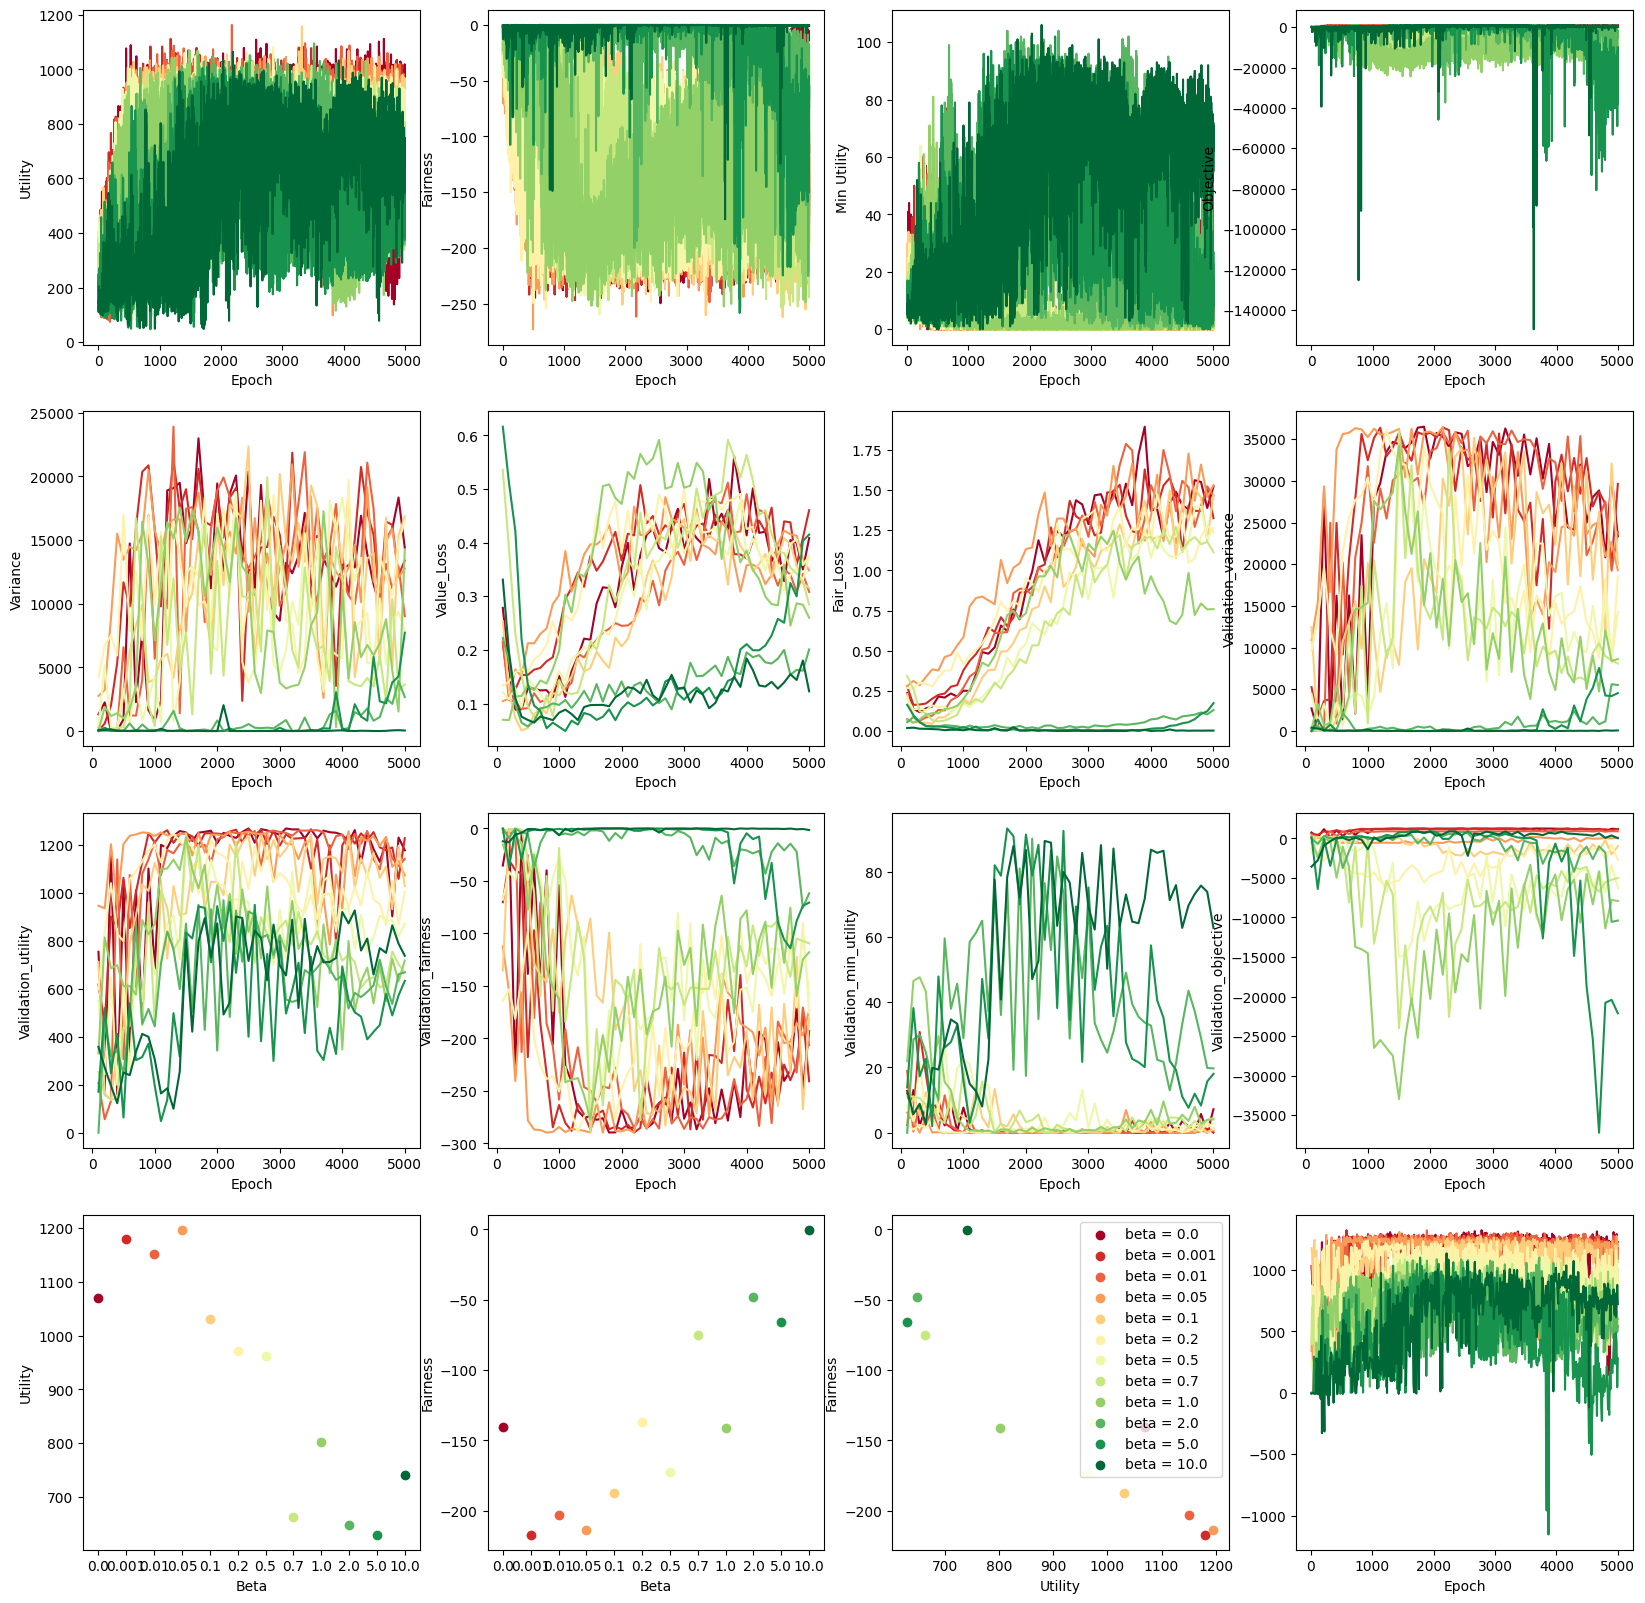

In [6]:
#With new features, lr=0.00003, using warm start50 and past discounting
logs = {
    "DDQN, 0": "matthew/logs/DoubleDQN/FixedComplex/0.0/1690319126/events.out.tfevents.1690319126.yoda.4051386.0.v2",
    "DDQN, 0.2": "matthew/logs/DoubleDQN/FixedComplex/0.2/1690319244/events.out.tfevents.1690319244.yoda.4056685.0.v2",
    "DDQN, 0.5": "matthew/logs/DoubleDQN/FixedComplex/0.5/1690319230/events.out.tfevents.1690319230.yoda.4055269.0.v2",
    "DDQN, 0.6": "matthew/logs/DoubleDQN/FixedComplex/0.6/1690346529/events.out.tfevents.1690346529.yoda.1529464.0.v2",
    "DDQN, 0.7" : "matthew/logs/DoubleDQN/FixedComplex/0.7/1690346545/events.out.tfevents.1690346545.yoda.1529770.0.v2",
    "DDQN, 0.8" : "matthew/logs/DoubleDQN/FixedComplex/0.8/1690346556/events.out.tfevents.1690346556.yoda.1530410.0.v2",
    "DDQN, 0.9" : "matthew/logs/DoubleDQN/FixedComplex/0.9/1690346565/events.out.tfevents.1690346565.yoda.1531786.0.v2",
    "DDQN, 1": "matthew/logs/DoubleDQN/FixedComplex/1.0/1690319181/events.out.tfevents.1690319181.yoda.4051989.0.v2", #really good!!
}
# #Central
# logs = {
#     "Central": "matthew/logs/CentralDDQN/FixedComplex/0.0/1690403142/events.out.tfevents.1690403142.yoda.43645.0.v2",
# }
# #Split: These runs had the SI bug. Same beta was accidentally being passed to SI
# logs = {
#     "Split, 0" : "matthew/logs/SplitDDQN_SI_bug/FixedComplex/0/1690660552/events.out.tfevents.1690660552.yoda.3766706.0.v2",
#     "Split, 0.2": "matthew/logs/SplitDDQN_SI_bug/FixedComplex/0.2/1690660616/events.out.tfevents.1690660616.yoda.3770933.0.v2",
#     "Split, 0.5" : "matthew/logs/SplitDDQN_SI_bug/FixedComplex/0.5/1690660640/events.out.tfevents.1690660640.yoda.3773723.0.v2",
#     "Split, 1" :  "matthew/logs/SplitDDQN_SI_bug/FixedComplex/1/1690660651/events.out.tfevents.1690660651.yoda.3774938.0.v2",
#     # "Split, 5" : "matthew/logs/SplitDDQN/FixedComplex/5/1690517309/events.out.tfevents.1690517309.yoda.250176.0.v2",
# }
#Split: Fixed SI bug. Still is learning to target U + beta*F
logs = {
    "Split, 0" : "matthew/logs/SplitDDQN/FixedComplex/0.0/1690697843/events.out.tfevents.1690697844.yoda.1926133.0.v2",
    "Split, 0.2": "matthew/logs/SplitDDQN/FixedComplex/0.2/1690697822/events.out.tfevents.1690697822.yoda.1921938.0.v2",
    "Split, 0.5" : "matthew/logs/SplitDDQN/FixedComplex/0.5/1690697861/events.out.tfevents.1690697861.yoda.1928430.0.v2",
    "Split, 0.6" : "matthew/logs/SplitDDQN/FixedComplex/0.6/1690733781/events.out.tfevents.1690733781.yoda.3784150.0.v2",
    "Split, 0.7" : "matthew/logs/SplitDDQN/FixedComplex/0.7/1690737347/events.out.tfevents.1690737347.yoda.269235.0.v2",
    "Split, 0.8" : "matthew/logs/SplitDDQN/FixedComplex/0.8/1690737404/events.out.tfevents.1690737405.yoda.285064.0.v2",
    "Split, 0.9" : "matthew/logs/SplitDDQN/FixedComplex/0.9/1690737426/events.out.tfevents.1690737426.yoda.290400.0.v2",
    "Split, 1" :  "matthew/logs/SplitDDQN/FixedComplex/1/1690697873/events.out.tfevents.1690697873.yoda.1930061.0.v2",
    # "Split Split, 1.0" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/1.0/1690860450/events.out.tfevents.1690860450.yoda.699676.0.v2",
}
# #Split: With split penalty by contribution. Found Bug: Was training starting from the buggy variance diff model.
# logs = {
#     "Split, 0" : "matthew/logs/SplitDDQN/FixedComplex_split_diff_bug/0.0/1690789906/events.out.tfevents.1690789906.yoda.3392701.0.v2",
#     "Split, 0.2" : "matthew/logs/SplitDDQN/FixedComplex_split_diff_bug/0.2/1690789915/events.out.tfevents.1690789915.yoda.3393096.0.v2",
#     "Split, 0.5" : "matthew/logs/SplitDDQN/FixedComplex_split_diff_bug/0.5/1690789923/events.out.tfevents.1690789923.yoda.3394254.0.v2",
#     "Split, 1.0" : "matthew/logs/SplitDDQN/FixedComplex_split_diff_bug/1.0/1690789933/events.out.tfevents.1690789933.yoda.3396111.0.v2",
# }
# # Split: With split penalty by contribution. Fixed bug with training with U+F (sad), restart.
logs = {
    "Split, 0" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.0/1690860347/events.out.tfevents.1690860347.yoda.690049.0.v2",
    "Split, 0.01" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.01/1690860415/events.out.tfevents.1690860415.yoda.694575.0.v2",
    "Split, 0.1" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.1/1690860431/events.out.tfevents.1690860431.yoda.696024.0.v2",
    "Split, 0.3" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.3/1691018516/events.out.tfevents.1691018516.yoda.710318.0.v2",
    "Split, 0.5" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.5/1691018471/events.out.tfevents.1691018471.yoda.705582.0.v2",
    "Split, 0.6" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.6/1691018541/events.out.tfevents.1691018541.yoda.715317.0.v2",
    "Split, 0.7" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/0.7/1691018488/events.out.tfevents.1691018488.yoda.706613.0.v2",
    "Split, 1.0" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/1.0/1690860450/events.out.tfevents.1690860450.yoda.699676.0.v2",
}
# # Split: With split penalty by contribution. Computing var of normalized su (by time steps) instead of raw su.
# logs = {
#     "Split, 0.1" : "matthew/logs/SplitDDQN_mod/FixedComplex_split_diff/0.1/1691123757/events.out.tfevents.1691123757.yoda.602864.0.v2",
#     "Split, 1" : "matthew/logs/SplitDDQN_mod/FixedComplex_split_diff/1/1691123782/events.out.tfevents.1691123782.yoda.606390.0.v2",
#     "Split, 10" : "matthew/logs/SplitDDQN_mod/FixedComplex_split_diff/10/1691123729/events.out.tfevents.1691123729.yoda.599776.0.v2",
#     "Split, 100" : "matthew/logs/SplitDDQN_mod/FixedComplex_split_diff/100/1691123748/events.out.tfevents.1691123748.yoda.601622.0.v2",
# }
# logs = get_logs("matthew/logs/SplitDDQN_mod/FixedComplex_split_diff/")
print(logs)

#Joint rew+split diff training
logs = get_logs("matthew/logs/DoubleDQN/FixedComplex_split_diff/")

#Best contenders
# logs = {
#     "DDQN (base), 0": "matthew/logs/DoubleDQN/FixedComplex/0.0/1690319126/events.out.tfevents.1690319126.yoda.4051386.0.v2",
#     "Central": "matthew/logs/CentralDDQN/FixedComplex/0.0/1690403142/events.out.tfevents.1690403142.yoda.43645.0.v2",
#     "DDQN w penalty, 1.0" : "matthew/logs/DoubleDQN/FixedComplex/1.0/1690319181/events.out.tfevents.1690319181.yoda.4051989.0.v2", #really good!!
#     "Split, var_diff, 1" :  "matthew/logs/SplitDDQN/FixedComplex/1/1690697873/events.out.tfevents.1690697873.yoda.1930061.0.v2",
#     "Split, Contribution, 1.0" : "matthew/logs/SplitDDQN/FixedComplex_split_diff/1.0/1690860450/events.out.tfevents.1690860450.yoda.699676.0.v2",
# }
keys = [ 'Utility', 'Fairness', 'Min_Utility', 'Value_Loss', "Validation_Utility", "Validation_Fairness", "Validation_Min_Utility" ]


#split both training test
logs = get_logs('matthew/logs/DDQN/FixedComplex/Split/split_diff/')
logs = get_logs('matthew/logs/DDQN/FixedComplex/Split/variance_diff/')
# logs = get_logs('matthew/logs/DDQN/FixedComplex/Joint/variance_diff/')
# logs = get_logs('matthew/logs/DDQN/FixedComplex/SplitNoUtility/variance_diff/')
# logs = get_logs('matthew/logs/DDQN/FixedComplex/SplitNoUtility/split_diff/')
keys = ['Utility', 'Fairness', 'Min Utility', 'Variance', 'Objective', 'VF1', 'VF2', 'Value_Loss', 'FF1', 'FF2', 'Fair_Loss', 'Validation_utility', 'Validation_fairness', 'Validation_min_utility', 'Validation_objective', 'Validation_variance']
keys = ['Utility', 'Fairness', 'Min Utility', 'Objective', 'Variance', 'Value_Loss', 'Fair_Loss', 'Validation_variance', 'Validation_utility', 'Validation_fairness', 'Validation_min_utility', 'Validation_objective', ]
betas = list(logs.keys())
logdirs = list(logs.values())

data = [read_tensorboard_log(logdir) for logdir in logdirs]
print(data[0].keys())


#Plot subfigures
fig = plt.figure(figsize=(20, 20))
#Red to green color gradient of length len(betas)
color_gradient = plt.cm.RdYlGn(np.linspace(0, 1, len(betas)))
#Different color gradient
# color_gradient = plt.cm.tab10(np.linspace(0, 1, len(betas)))
for j, logdir in enumerate(logdirs):
    for i, key in enumerate(keys):
        if key not in data[j].keys():
            continue
        x = data[j][key][0]
        y = data[j][key][1]

        #plot a smoothed curve
        if i>3:
            if len(x)>200:
                y = [y[i] for i in range(len(y)) if x[i]%100==0]
                x = [x[i] for i in range(len(x)) if x[i]%100==0]
            y_smooth = pd.DataFrame(y).fillna(method='bfill').fillna(method='ffill').rolling(1, ).mean()    
            #select every point where x%100==0
        else:
            y_smooth = pd.DataFrame(y).rolling(1).mean()
        # y_smooth = y
        df = pd.DataFrame({'Epoch': x, key: y_smooth[0]})
        plt.subplot(4, 4, i+1)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        plt.plot(x, y_smooth, label = 'beta = ' + str(betas[j]), color = color_gradient[j])
    # #Plot Validation Utility vs Validation Fairness
    # x = data[j]['Validation_Utility'][1][-10:]
    # y = data[j]['Validation_Fairness'][1][-10:]
    # y_smooth = pd.DataFrame(y).rolling(10).mean()
    # plt.subplot(4, 2, 8)
    # plt.scatter(x, y_smooth, label = 'beta = ' + str(betas[j]), color = color_gradient[j])
    # plt.xlabel('Validation Utility')
    # plt.ylabel('Validation Fairness')

    #plot utility vs beta
    plt.subplot(4, 4, 13)
    y = np.mean(data[j]['Validation_utility'][1][-10:])
    plt.scatter(betas[j], y, label = 'beta = ' + str(betas[j]), color = color_gradient[j])
    #make x axis log scale
    # plt.xscale('log')
    plt.xlabel('Beta')
    plt.ylabel('Utility')

    #plot fairness vs beta
    plt.subplot(4, 4, 14)
    y = np.mean(data[j]['Validation_fairness'][1][-10:])
    # y = np.mean(data[j]['Validation_variance'][1][-10:])
    plt.scatter(betas[j], y, label = 'beta = ' + str(betas[j]), color = color_gradient[j])
    #make x axis log scale
    # plt.xscale('log')
    plt.xlabel('Beta')
    plt.ylabel('Fairness')


    #Plot validation_utility - validation_fairness vs epoch
    plt.subplot(4, 4, 16)
    x = data[j]['Validation_utility'][0]
    x1 = data[j]['Validation_utility'][1]
    x2 = data[j]['Validation_fairness'][1]
    # print(len(x1), len(x2), betas[j])
    y = [float(x1[i]) + float(betas[j])*float(x2[i]) for i in range(len(x1))]
    # y = [float(x1[i])**0.5 for i in range(len(x1))]
    y_smooth = pd.DataFrame(y).rolling(1).mean()
    plt.plot(x, y_smooth, label = 'beta = ' + str(betas[j]), color = color_gradient[j])
    plt.xlabel('Epoch')
    plt.ylabel('U + F')

    #plot fairness vs utility
    plt.subplot(4, 4, 15)
    x = np.mean(data[j]['Validation_utility'][1][-10:])
    y = np.mean(data[j]['Validation_fairness'][1][-10:])
    plt.scatter(x, y, label = 'beta = ' + str(betas[j]), color = color_gradient[j])
    plt.xlabel('Utility')
    plt.ylabel('Fairness')


plt.legend()
plt.show()

# #for each data, plot the final value: x-axis=Valiadtion Utility, y-axis=Validation Fairness
# fig = plt.figure(figsize=(10, 10))
# xs = []
# ys = []
# for i, logdir in enumerate(logdirs):
#     x = data[i]['Validation_Utility'][1][-1]
#     y = data[i]['Validation_Fairness'][1][-1]
#     xs.append(x)
#     ys.append(y)
#     plt.scatter(x, y, label = 'beta = ' + str(betas[i]), color = color_gradient[i])
#     #Add text
#     plt.text(x, y, betas[i], fontsize=12)

# plt.plot(xs, ys, color = 'black')

# plt.xlabel('Validation Utility')

# plt.ylabel('Validation Fairness')
# plt.legend()
# plt.show()


In [ ]:
dit
# #plot 2x2 subfigures using plotly
for i, key in enumerate(keys):
    x = []
    y = []
    beta = []
    for j in range(len(data)):
        x.extend(data[j][key][0])
        y_smooth = pd.DataFrame(data[j][key][1]).rolling(1).mean()[0]
        y.extend(y_smooth)
        beta.extend([betas[j] for _ in range(len(data[j][key][0]))])

    print(key)
    #plot a smoothed curve
    
    # y_smooth = y
    #change the size of the figure
    px.defaults.width = 800
    # print(len(x), len(y), len(beta))
    df = pd.DataFrame({'Epoch': x, key: y,'beta': beta})
    fig = px.line(df, x='Epoch', y=key, title=key, color='beta')
    fig.show()

NameError: name 'dit' is not defined

In [74]:
import os
os.listdir('logs/OnPolicyVF/Reallocate/')

['1688280275',
 '1688414233',
 '1688403328',
 '1688243545',
 '1688242381',
 '1688251313']

In [16]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
# %reload_ext tensorboard
# %tensorboard --logdir runs --host localhost --port 8888
# # !kill 2976453
# # 
# # tensorboard dev upload --logdir logs/OnPolicyVF     --name "Experiments for FEN code, MARL"     --description "Training for efficiency"

You can detach from your tmux session by pressing Ctrl+B then D. Tmux operates using a series of keybindings (keyboard shortcuts) triggered by pressing the "prefix" combination. By default, the prefix is Ctrl+B. After that, press D to detach from the current session.

You're no longer attached to the session, but your long-running command executes safely in the background. You can list active tmux sessions with tmux ls:

You can disconnect your SSH connection at this point, and the command will continue to run. When you're ready, reconnect to the server and reattach to the existing tmux session to resume where you left off:

$ tmux attach -t 0
Hello 72
Hello 73
Hello 74
Hello 75
Hello 76
^C

As you can see, the command continued to run and print messages on the screen. You can type Ctrl+C to cancel it.

All tmux commands can also be abbreviated, so, for example, you can enter tmux a , and it will work the same as tmux attach.

This functionality alone makes tmux a great tool, but it has even more to offer, including its default keybindings.

In [15]:
n = 10 #number of groups
#initial. One for each group
zs = [0.5 for i in range(n)]
var_z = np.var(zs)  #variance of zs
#initial counts
sz = 100
counts = [sz for i in range(n)]
#Allocation at time t
zt = [0.6 for i in range(n)] #For each group
counts_t = [np.random.randint(5) for i in range(n)] #How many to allocate at zt_i
#Update
zs_new = [i for i in zs]
for i in range(n):
    zs_new[i] = (zs[i]*counts[i] + zt[i]*counts_t[i])/(counts[i]+counts_t[i])
    counts[i] = counts[i]+counts_t[i]
print(zs_new)
print(counts_t)
new_var_z = np.var(zs_new)

#Delta var_z
D_vz = new_var_z - var_z

#Closed form expression of D_vz based on zs and zt

#How much did group i contribute to the change in variance
D_vz_i = ???


[0.500990099009901, 0.500990099009901, 0.500990099009901, 0.500990099009901, 0.5, 0.5038461538461538, 0.5, 0.500990099009901, 0.500990099009901, 0.5029126213592233]
[1, 1, 1, 1, 0, 4, 0, 1, 1, 3]


In [50]:
def get_fairness_from_su(su_prev, su_post, ftype="variance", action=None):
	# su_prev and su_post are lists of discounted utilities
	n_agents = len(su_prev)
	# ftype is the type of fairness to compute. Currently, only variance is supported
	if ftype=="variance":
		return [-np.var(su_post)/n_agents for i in range(n_agents)]
	elif ftype=="variance_diff":
		return [-np.var(su_post)/n_agents + np.var(su_prev)/n_agents for i in range(n_agents)]
	elif ftype=="split_diff":
		#Each agent gets score based on how much they contributed
		su_post = [su_prev[i] + int(bool(action[i]+1)) for i in range(n_agents)]
		scores = [0 for i in range(n_agents)]
		zbar = np.mean(su_prev)
		z2bar = np.mean(su_post)
		print(np.var(su_post)/z2bar, np.var(su_prev)/zbar)
		# z2bar = zbar
		for i in range(n_agents):
			z_i = su_prev[i]
			z_i2 = su_post[i]
			scores[i] = -((z_i2 -z2bar)**2 - (z_i - zbar)**2)/n_agents/z2bar   #The exact contribution. Not an estimate.
		return scores
	elif ftype=='SI':
		zbar = np.mean(su_prev)
		scores = [0 for i in range(n_agents)]
		for i in range(n_agents):
			z_i = su_prev[i]
			z2_i = su_post[i]
			scores[i] = 2*(z_i - zbar)*(z2_i - z_i)
			# scores[i] = 2*(z_i - zbar)*(action[i])
		return scores
	else:
		print("Fairness type not supported. Exiting")
		exit()


In [51]:
s1 = [1,1,1,1,250,250,50]
action = [0,0,1,0,0,0,0]
action = [a-1 for a in action]
s2 = [s1i + ai for s1i, ai in zip(s1, action)]
ftype = "variance"
ftype = 'variance_diff'
ftype = 'split_diff'
# ftype = 'SI'
f = get_fairness_from_su(s1, s2, ftype=ftype, action = action)
print(sum(f), f)

150.45662805662806 151.00876740587935
0.28005148005146324 [-0.04026475455047074, -0.04026475455047074, 0.2400441257584093, -0.04026475455047074, 0.08792057363485534, 0.08792057363485534, -0.015039529325244492]


# Analysis of beta region experiment

In [7]:
# results = pd.read_csv("matthew/Results_SplitDDQN.csv")
# results = pd.read_csv("matthew/Results_SplitDDQN_50.csv")
# results = pd.read_csv("matthew/Results_SplitDDQN_2.csv")
# results = pd.read_csv("matthew/Results_SplitDDQN_both_bestm_50.csv")
# results = pd.read_csv('matthew/Results_SplitDDQN_both_5000m_50.csv')
# results = pd.read_csv("matthew/Results_SplitDDQN_vardiff_both_bestm_50.csv")
# results = pd.read_csv("matthew/Results_SplitDDQN_vardiff_both_5000m_50.csv")

results = pd.read_csv("matthew/Results/BetaSweep/SplitDDQN_split_diff_bestm_50.csv")
results = pd.read_csv("matthew/Results/BetaSweep/SplitDDQN_variance_diff_bestm_50.csv")
# results = pd.read_csv("matthew/Results/BetaSweep/SplitDDQN_split_diff_both_bestm_50.csv")
# results = pd.read_csv("matthew/Results/BetaSweep/SplitDDQN_variance_diff_both_bestm_50.csv")
results['base_beta'] = results['base_beta'].round(6)

In [8]:
results['base_beta'].unique()

array([0.e+00, 1.e-03, 1.e-02, 5.e-02, 1.e-01, 2.e-01, 5.e-01, 7.e-01,
       1.e+00, 2.e+00, 5.e+00, 1.e+01])

In [9]:
#plot fairness vs utility, one line for each base beta
import plotly.express as px
import plotly.graph_objects as go
results.sort_values(by=['beta'], inplace=True)
#filter rows where base_beta/10<beta<base_beta*10
# area = 10000
# results = results[results['beta']>=results['base_beta']/area]
# results = results[results['beta']<=results['base_beta']*area]

fig = px.line(results, x="utility", y="fairness", color="base_beta", hover_name="beta", markers=True)
# fig = px.line(results, x="utility", y="variance", color="base_beta", hover_name="beta", markers=True)
# fig.update_layout(yaxis_type="log")

#add points for rows where beta=base_beta
# fig = go.Figure()
# for i, row in results.iterrows():
#     if row['beta']==row['base_beta']:
#         fig.add_trace(go.Scatter(x=[row['utility']], y=[row['fairness']], mode='markers'))
fig.show()

In [10]:
#plot fairness vs utility, one line for each base beta
import plotly.express as px
import plotly.graph_objects as go
results.sort_values(by=['beta'], inplace=True)
fig = px.line(results, x="beta", y="variance", color="base_beta", hover_name="beta", markers=True)
#make x axis log scale\
fig.update_layout(xaxis_type="log")
fig.update_layout(yaxis_type="log")
fig.show()

fig = px.line(results, x="beta", y="utility", color="base_beta", hover_name="beta", markers=True)
#make x axis log scale\
fig.update_layout(xaxis_type="log")
fig.show()


## Base model comparison

In [46]:
# matthew/Results/Base/DDQN_variance_diff_both_bestm_50.csv
results = pd.read_csv("matthew/Results/Base/DDQN_variance_diff_both_bestm_50.csv")
results['Method'] = "DDQN, vardiff"
#matthew/Results/Base/DDQN_split_diff_both_bestm_50.csv
results1 = pd.read_csv("matthew/Results/Base/DDQN_split_diff_both_bestm_50.csv")
results1['Method'] = "DDQN, splitdiff"
#matthew/Results/Base/SplitDDQN_split_diff_both_bestm_50.csv
results2 = pd.read_csv("matthew/Results/Base/SplitDDQN_split_diff_both_bestm_50.csv")
results2['Method'] = "SplitDDQN, splitdiff"
#matthew/Results/Base/SplitDDQN_variance_diff_both_bestm_50.csv
results3 = pd.read_csv("matthew/Results/Base/SplitDDQN_variance_diff_both_bestm_50.csv")
results3['Method'] = "SplitDDQN, vardiff"
#matthew/Results/Base/SplitDDQN_variance_diff_bestm_50.csv
results4 = pd.read_csv("matthew/Results/Base/SplitDDQN_variance_diff_bestm_50.csv")
results4['Method'] = "SplitDDQN no util, vardiff"
#matthew/Results/Base/SplitDDQN_split_diff_bestm_50.csv
results5 = pd.read_csv("matthew/Results/Base/SplitDDQN_split_diff_bestm_50.csv")
results5['Method'] = "SplitDDQN no util, splitdiff"
#Combine
results = pd.concat([results, results2, results3, results1, results4, results5], ignore_index=True)
results['base_beta'] = results['base_beta'].round(6)
results['beta'] = results['beta'].round(6)
#plot utility vs fairness
fig = px.line(results, x="utility", y="fairness", color='Method', title="Utility vs Fairness", text='beta')
fig.show()

#plot utility vs beta(log scale)
fig = px.line(results, x="beta", y="utility", color='Method', title="Utility vs Beta", text='base_beta', log_x=True)
fig.show()

#plot fairness vs beta(log scale)
fig = px.line(results, x="beta", y="fairness", color='Method', title="Fairness vs Beta", text='base_beta', log_x=True)
fig.show()


Talking point
1. Model selection issue
Variance scale vs utility scale
1.5 There is also a beta scaling difference between the various methods. Optima are at different points
2. There is an optimal solution with high fairness and high utility, past a valley of utility reduction
    (Around 1100 util 0 fairness)
3. The joint method reaches this at the extreme with variance diff
    Also with split diff, but at a much lower beta
4. The split method reaches this point, but not consistently, and also not at the limit
    There is high variance. Could be a model selection issue
5. For the split methods, variance penalty leads to a high variability in model performance.

Big issues: Model selection, beta resolution, result reporting

In [ ]:
Try shared weights
Try 100 iter of util then 100 of fairneaa
Use std instead of variance

New beta region experiments

In [ ]:
loc = "matthew/Results/BetaSweep"
files = os.listdir(loc)
filenames = [f for f in files if ".csv" in f]
both = ["" for f in filenames if "_both" in f else "No Utility"]
var_diff = ["Var" for f in filenames if "_variance_diff" in f else "Agent"]
expt_names = {f[i]: f"Split, {both[i]}, {var_diff[i]}" for i in range(len(filenames))}

results = pd.DataFrame(columns=['utility', 'fairness', 'min_utility', 'objective', 'variance', 'beta', 'base_beta', 'expt_name'])
for i, f in enumerate(filenames):
    df = pd.read_csv(loc+"/"+f)
    df['expt_name'] = expt_names[f]
    results = results.append(df, ignore_index=True)

#plot
